# Estimating archaic TMRCAs from the real data

In [1]:
suppressPackageStartupMessages({
library(tidyverse)
library(magrittr)
library(here)
library(furrr)
library(scales)
library(lemon)
library(cowplot)

devtools::load_all(".")
})

plan(multiprocess)

Loading ychr


### Estimate TMRCA of A00 and present-day non-Africans

In [2]:
highcov_gt <- read_vcf(here("data/vcf/full_highcov.vcf.gz"), mindp = 3, maxdp = 0.98)

In [3]:
step1 <- run_step1(highcov_gt)

In [4]:
step1 %>% summarise_if(is.numeric, mean)

a,b,c,d,e,f,total,mut_rate,tmrca_afr
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
608.0385,1.884615,7.923077,200.3077,12,705.3462,5818142,7.191712e-10,170063.3


# Influence of `mindp` on TMRCA

In [5]:
tmrca_df <- readRDS(here("data/rds/tmrca_df.rds"))

### TMRCA vs coverage

`geom_smooth()` using method = 'loess' and formula 'y ~ x'


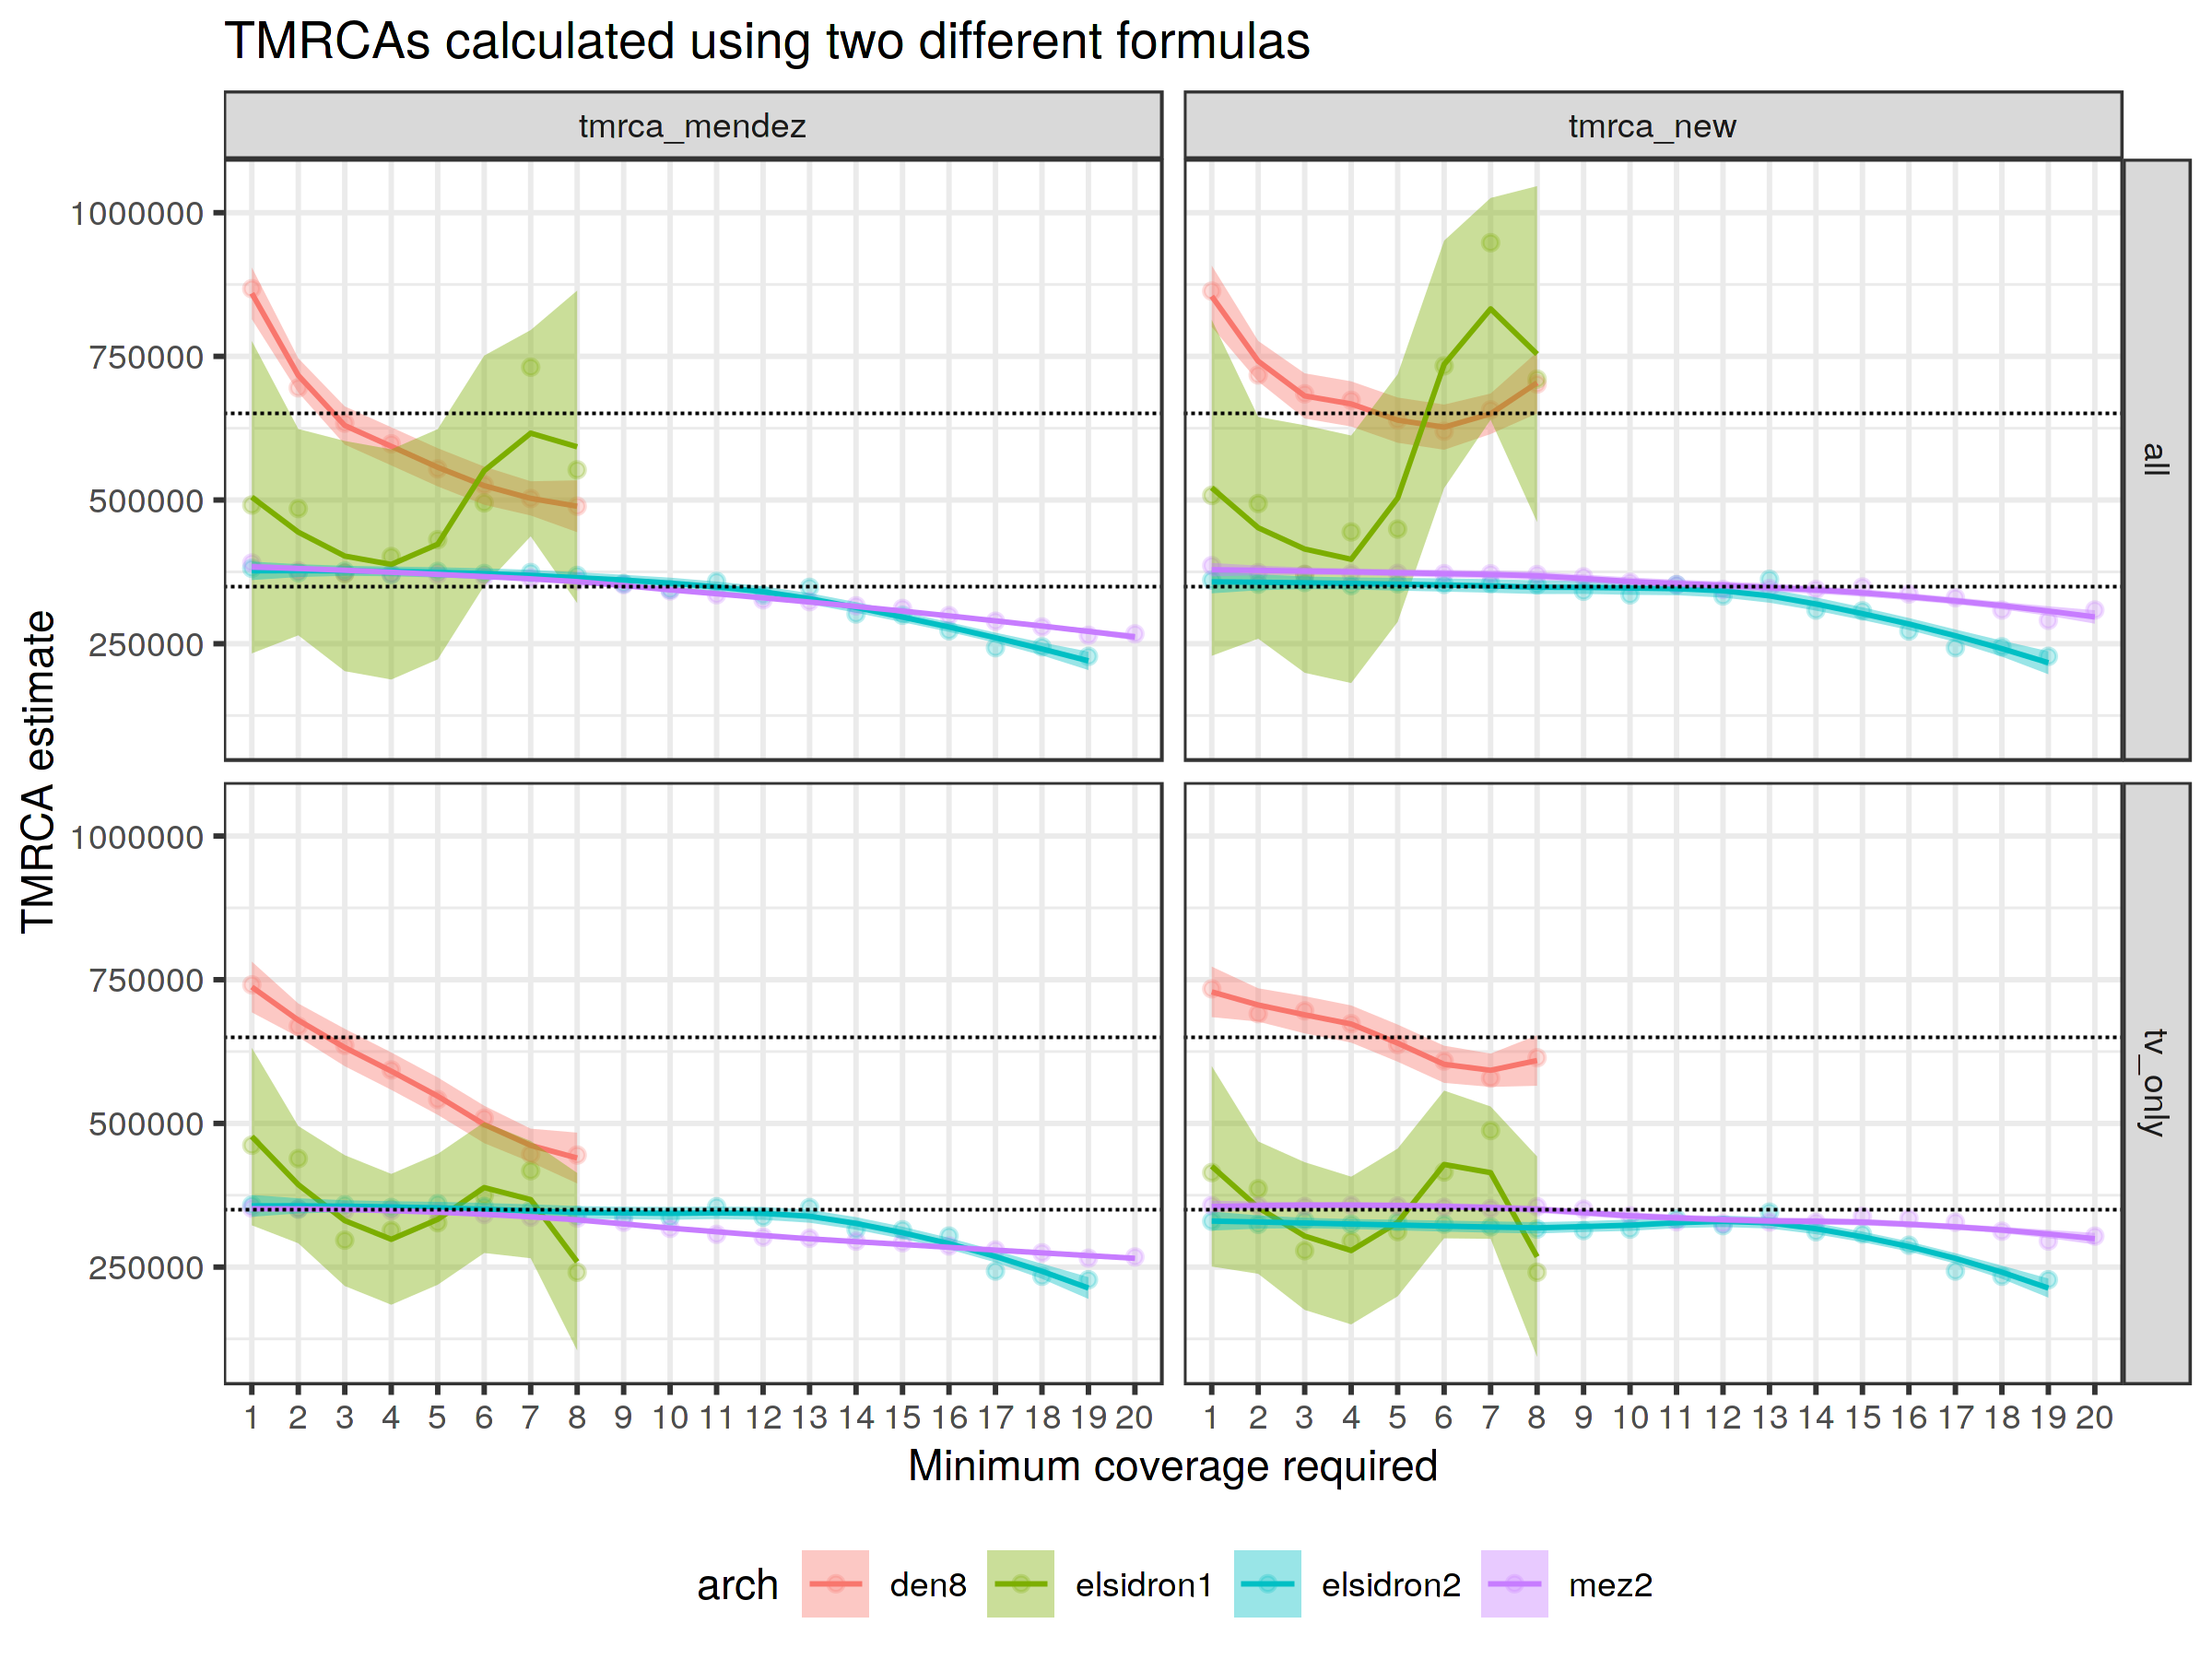

In [6]:
set_dim(8, 6)

tmrca_df %>%
filter(filt == "filt50", capture == "full" & arch %in% c("den8", "mez2") | capture == "lippold" & arch == "elsidron2" | capture == "exome" & arch == "elsidron1") %>%
filter(!is.infinite(tmrca_new), !is.nan(tmrca_new),
       !is.infinite(tmrca_mendez), !is.nan(tmrca_mendez)) %>%
select(arch, tmrca_new, tmrca_mendez, sites, dp) %>%
group_by(arch, sites, dp) %>%
summarise_all(mean) %>% 
gather(tmrca, value, -c(arch, sites, dp)) %>%
ggplot(aes(dp, value, color = arch)) +
    geom_point(aes(as.factor(dp), value), alpha = 1/4) +
    geom_smooth(aes(fill = arch), size = 0.5) +
    labs(x = "Minimum coverage required", y = "TMRCA estimate") +
    theme_bw() +
    facet_grid(sites ~ tmrca) +
    theme(legend.position = "bottom") +
    ggtitle("TMRCAs calculated using two different formulas") +
    geom_hline(yintercept = c(350000, 650000), linetype = 2, size = 1/3)

# Why do `d` and `e` counts differ so much depending on coverage?

In [7]:
tmrca_df %>%
filter(filt == "filt50", capture == "full" & arch %in% c("den8"), sites == "all") %>%
mutate(n_muts = a + b + c + d + e + f) %>% select(-starts_with("tmrca"), -mut_rate) %>%
group_by(arch, dp) %>%
summarise_if(is.numeric, mean) %>%
arrange(dp)

arch,dp,a,b,c,d,e,f,total,n_muts
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
den8,1,2228.92308,60.3846154,23.923077,873.69231,861.30769,20670.15385,5044486.8,24718.3846
den8,2,1296.23077,42.6923077,19.000000,664.38462,729.53846,2862.23077,4242870.5,5614.0769
den8,3,840.61538,32.3846154,13.538462,463.00000,583.30769,1095.15385,3329372.6,3028.0000
den8,4,522.00000,21.7692308,10.461538,295.15385,420.38462,621.23077,2432617.4,1891.0000
den8,5,292.38462,7.8461538,8.769231,179.61538,277.23077,359.15385,1652991.2,1125.0000
den8,6,162.15385,3.8461538,2.307692,105.07692,173.38462,206.30769,1047051.1,653.0769
den8,7,83.92308,0.8461538,1.615385,49.84615,107.53846,103.46154,615606.8,347.2308
den8,8,42.92308,0.0000000,1.230769,23.38462,61.53846,52.92308,333660.5,182.0000


Note that the `a` length is getting A LOT shorter as we increase the coverage cutoff.

d/e ~1 for DP == 1, as it should be, but the ratio keeps getting more and more skewed with DP > 1

### The `a` branch is getting increasingly shorter than `e` the higher the required coverage cutoff is

But note that it's the same even for Mez2! Not Denisova-specific ref bias then.

Warning message:
“Removed 2 rows containing missing values (geom_point).”

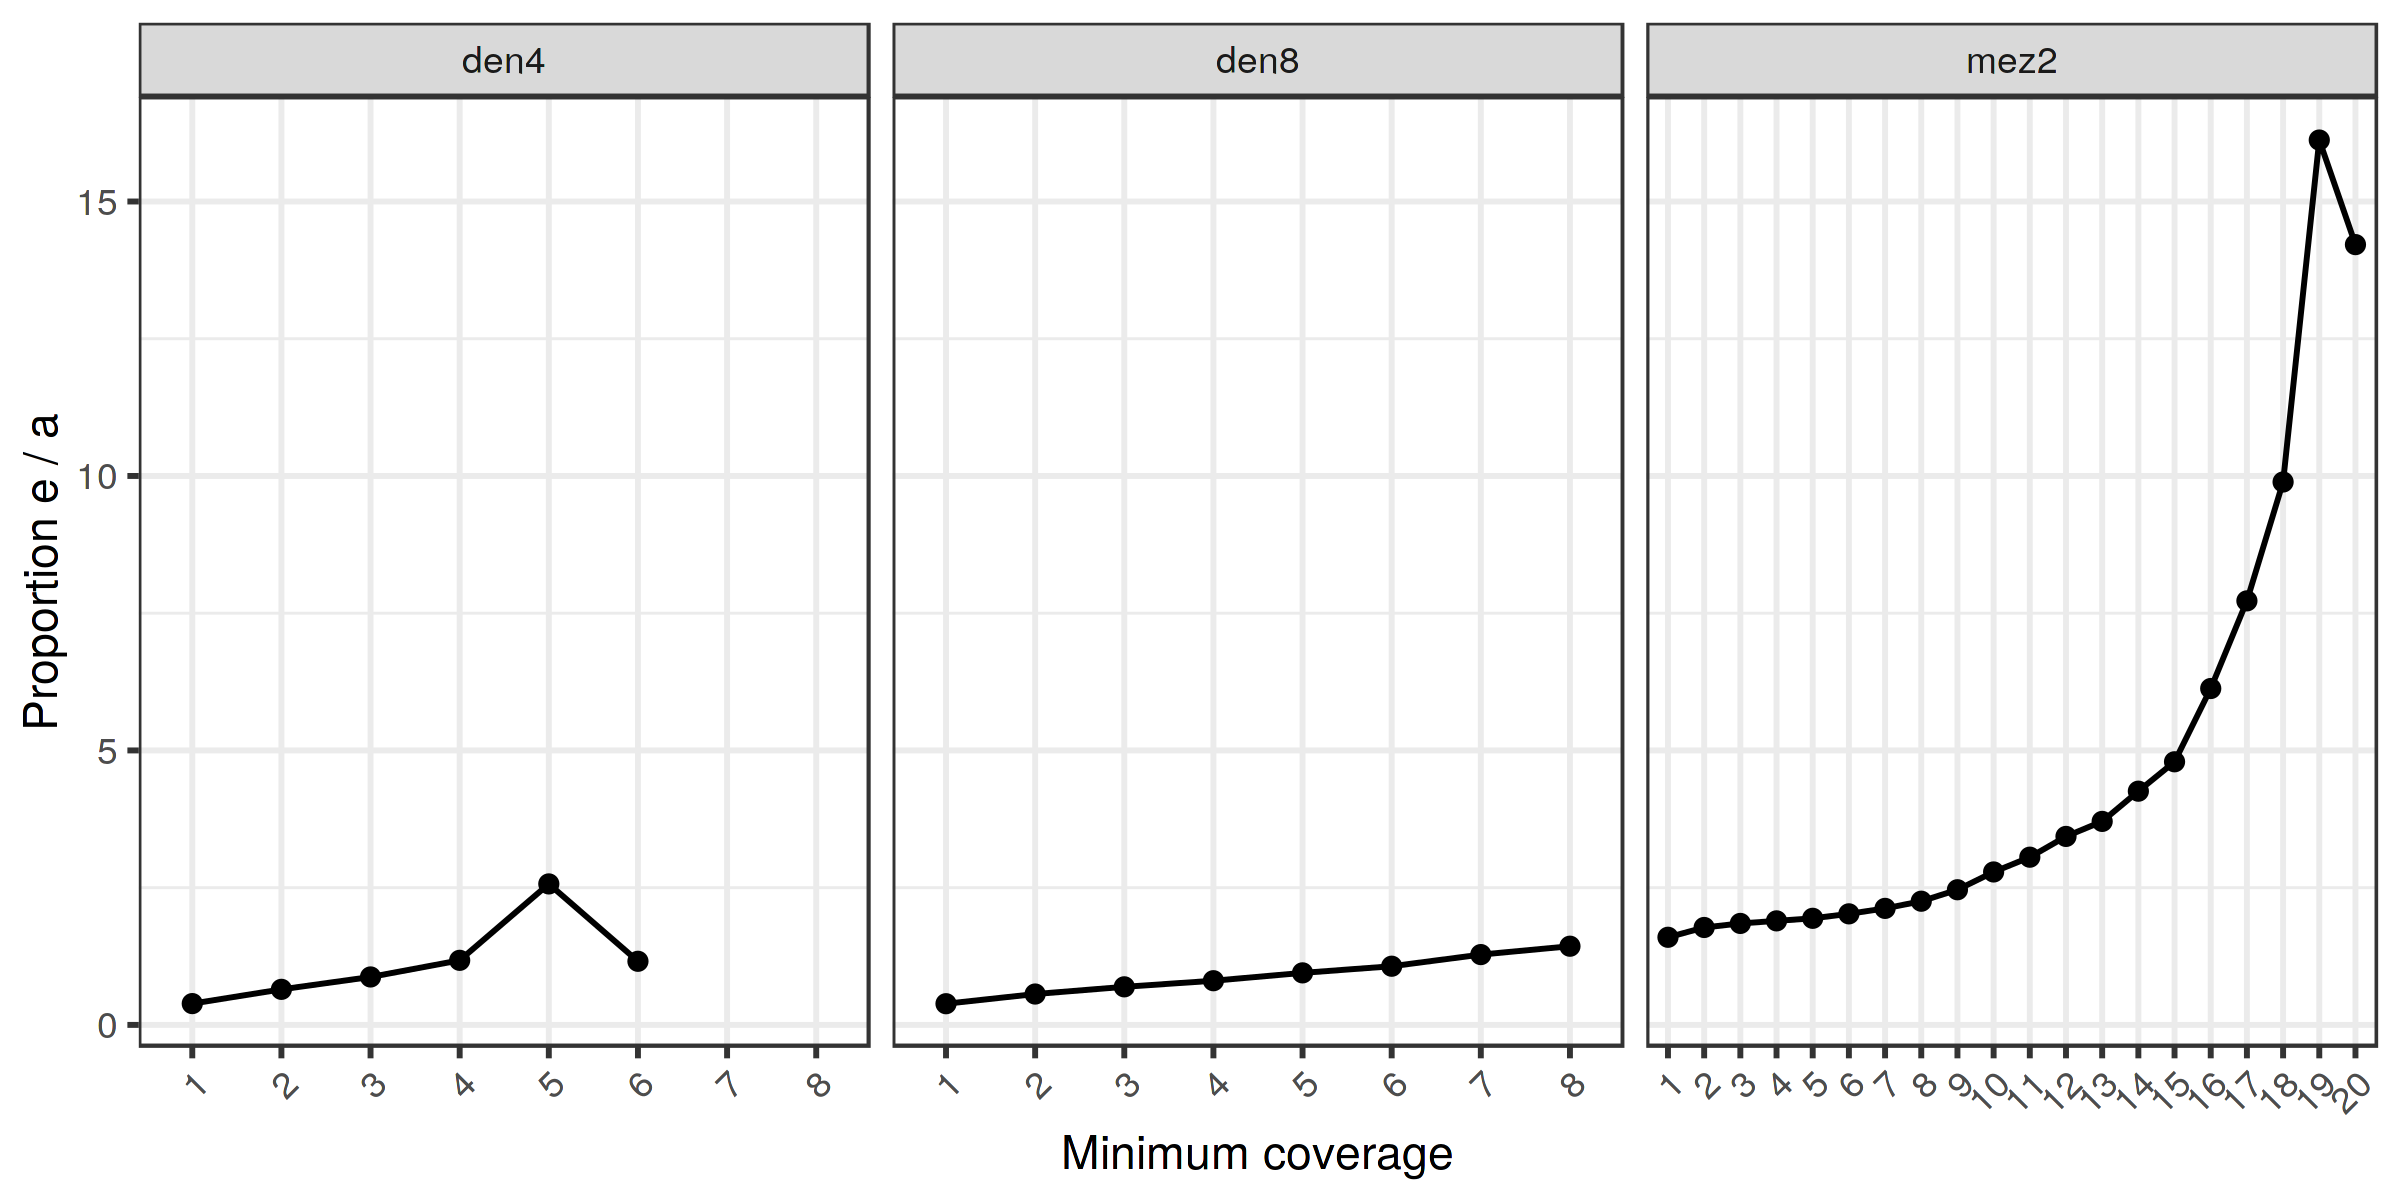

In [8]:
set_dim(8, 4)

tmrca_df %>%
filter(filt == "filt50", sites == "all", capture == "full" & arch %in% c("den4", "den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### ... but not the `d` branch... ?

Warning message:
“Removed 2 rows containing missing values (geom_point).”

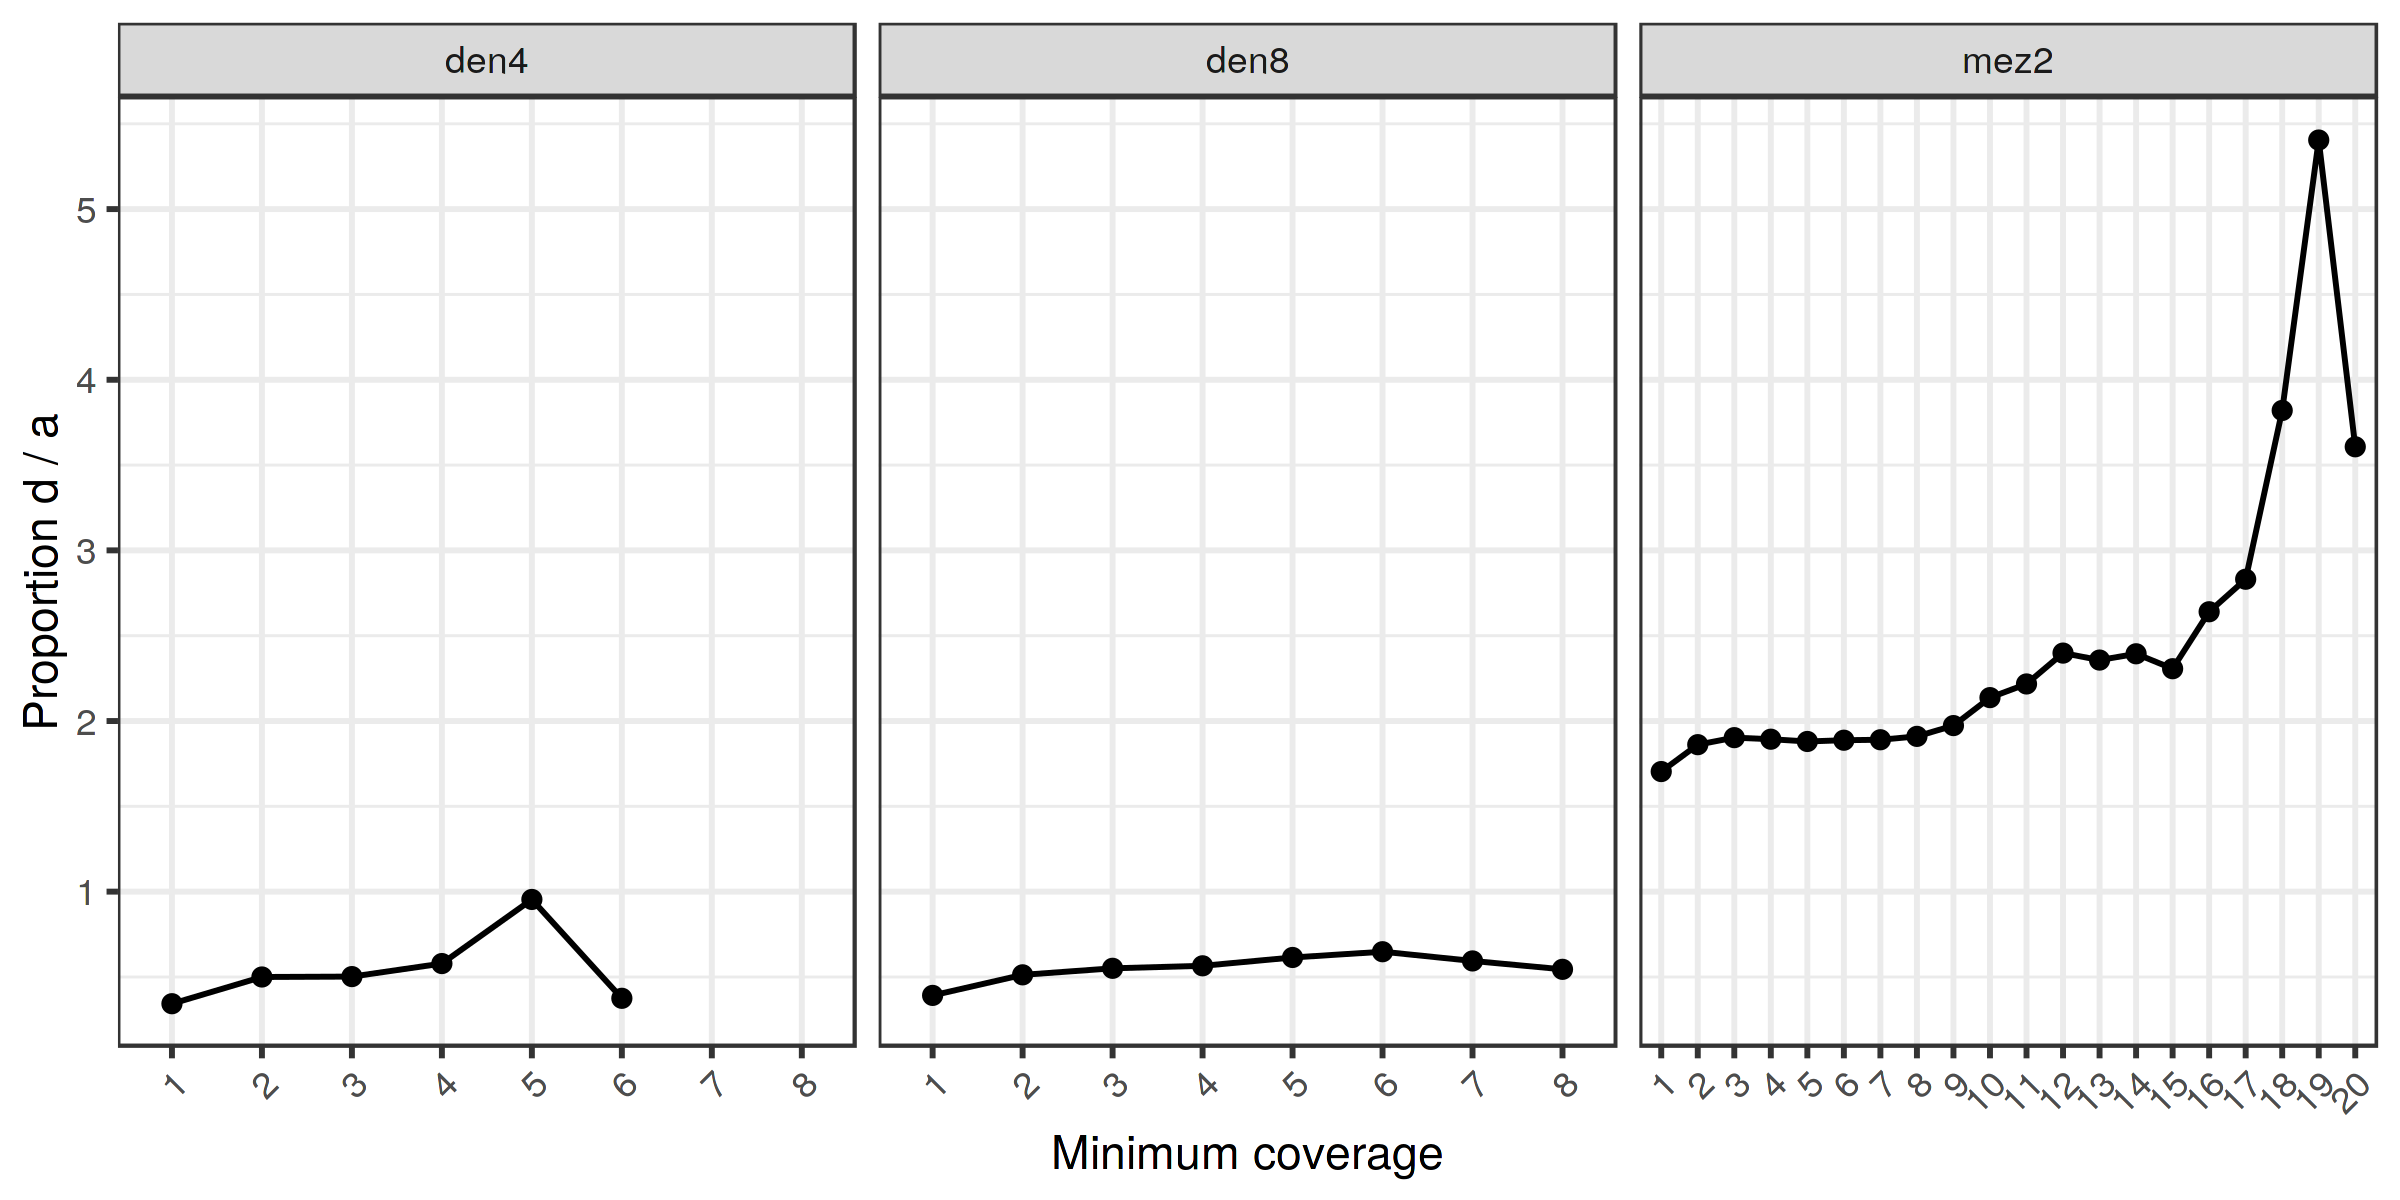

In [9]:
set_dim(8, 4)

tmrca_df %>%
filter(filt == "filt50", sites == "all", capture == "full" & arch %in% c("den4", "den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = d / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion d / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### What about `d` vs `e`? This proportion should be ~1.

Warning message:
“Removed 2 rows containing missing values (geom_point).”

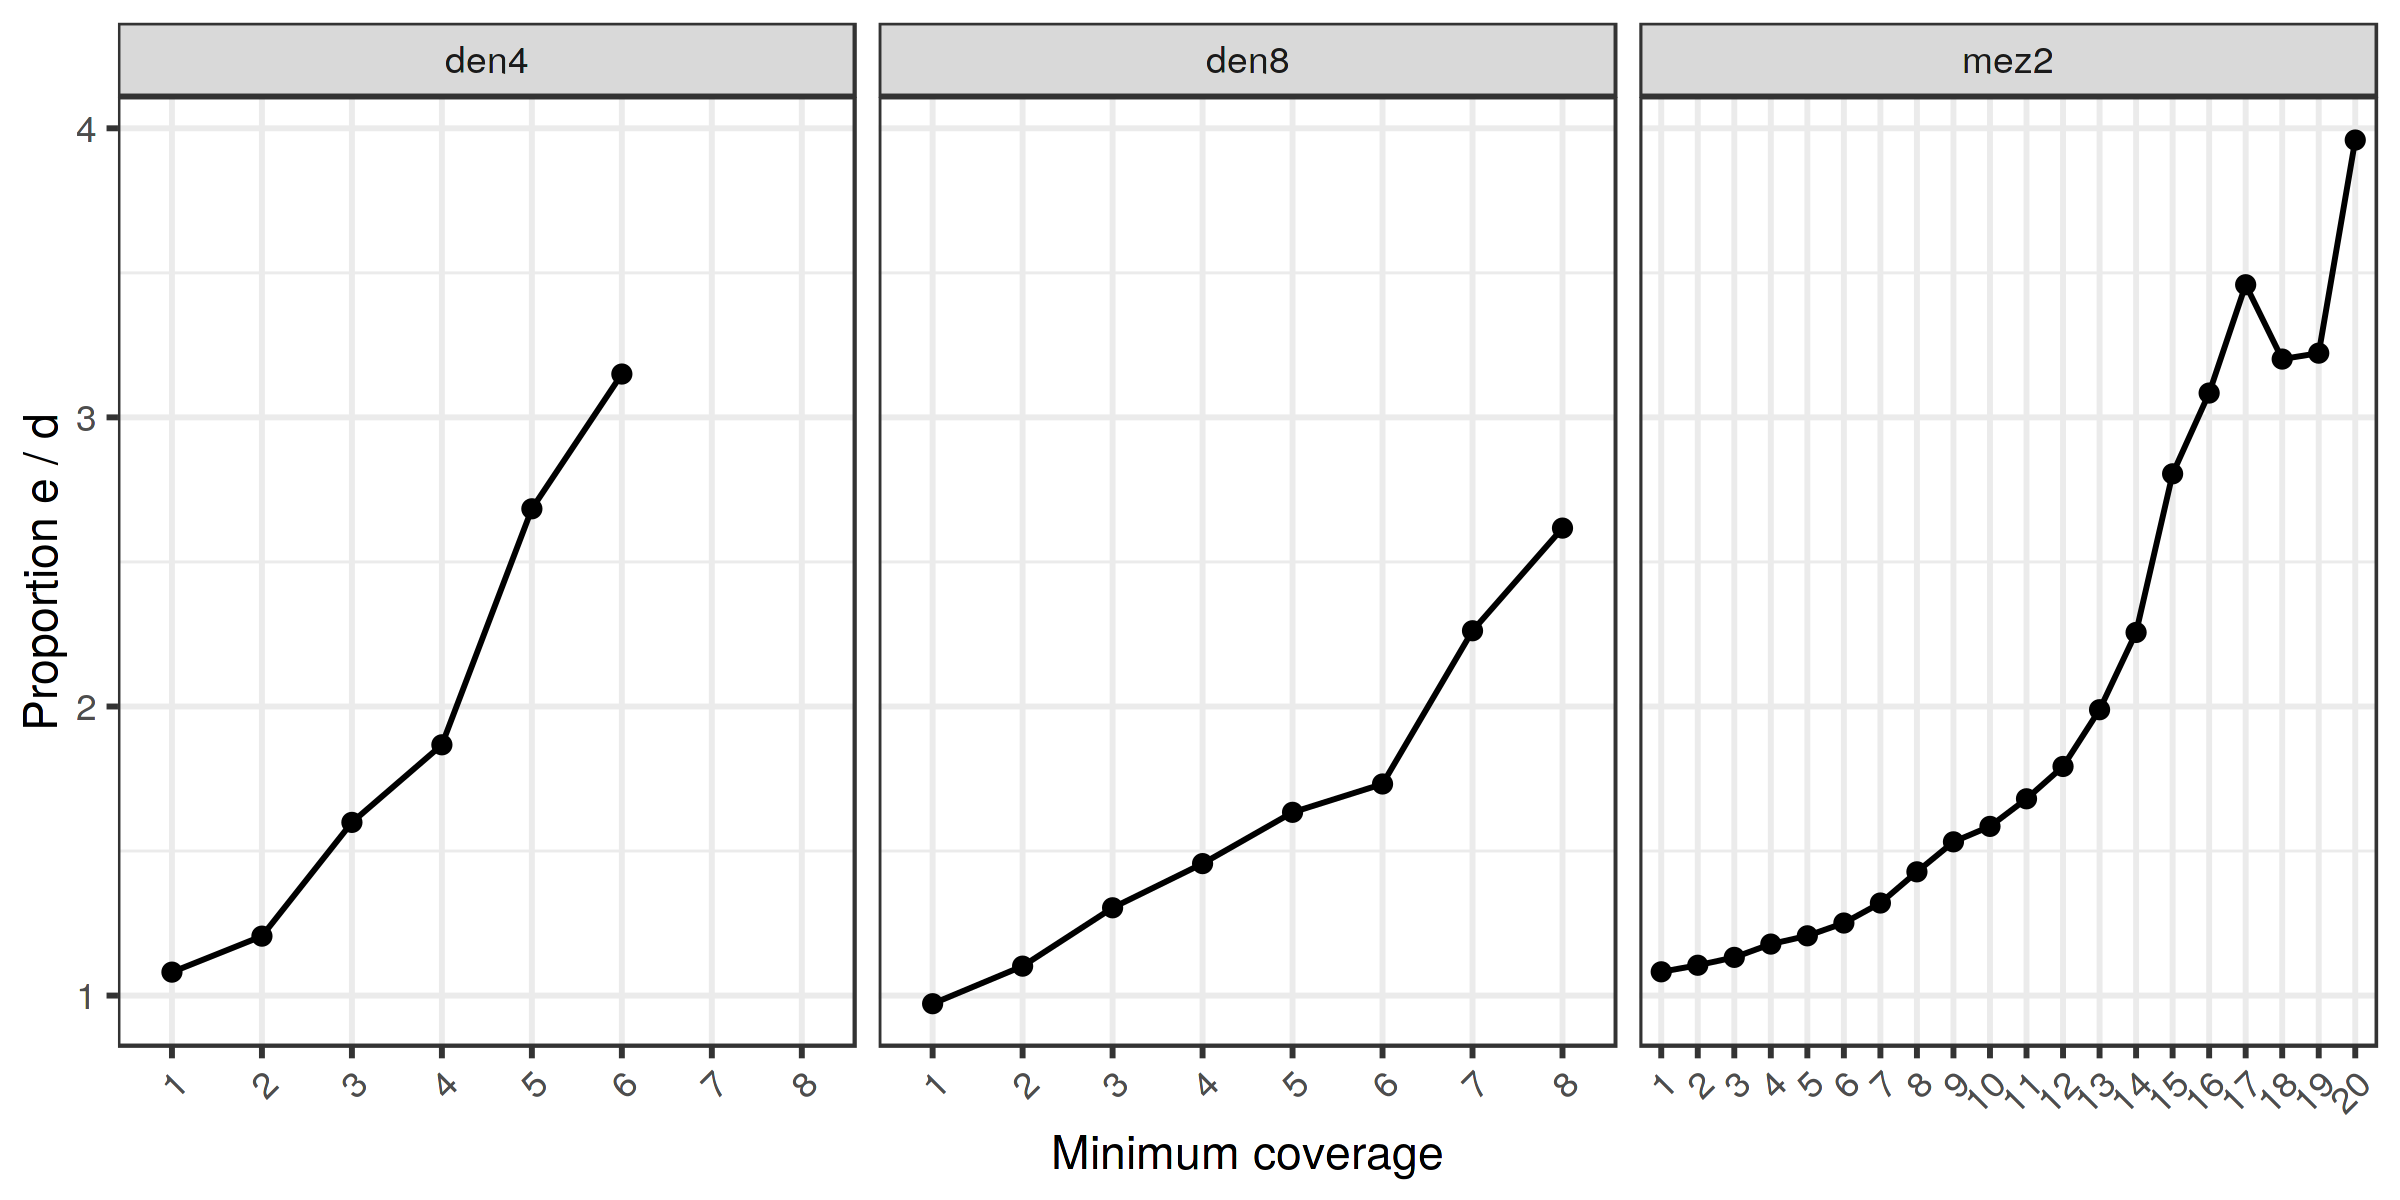

In [10]:
set_dim(8, 4)

tmrca_df %>%
filter(filt == "filt50", sites == "tv_only", capture == "full" & arch %in% c("den4", "den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = e / d) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_grid(. ~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion e / d") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

### Branches `b` and `c` are a measure of back mutations/contamination/errors

Their relationships should be pretty much constant, even with respect to other branch counts.

Warning message:
“Removed 2 rows containing missing values (geom_point).”

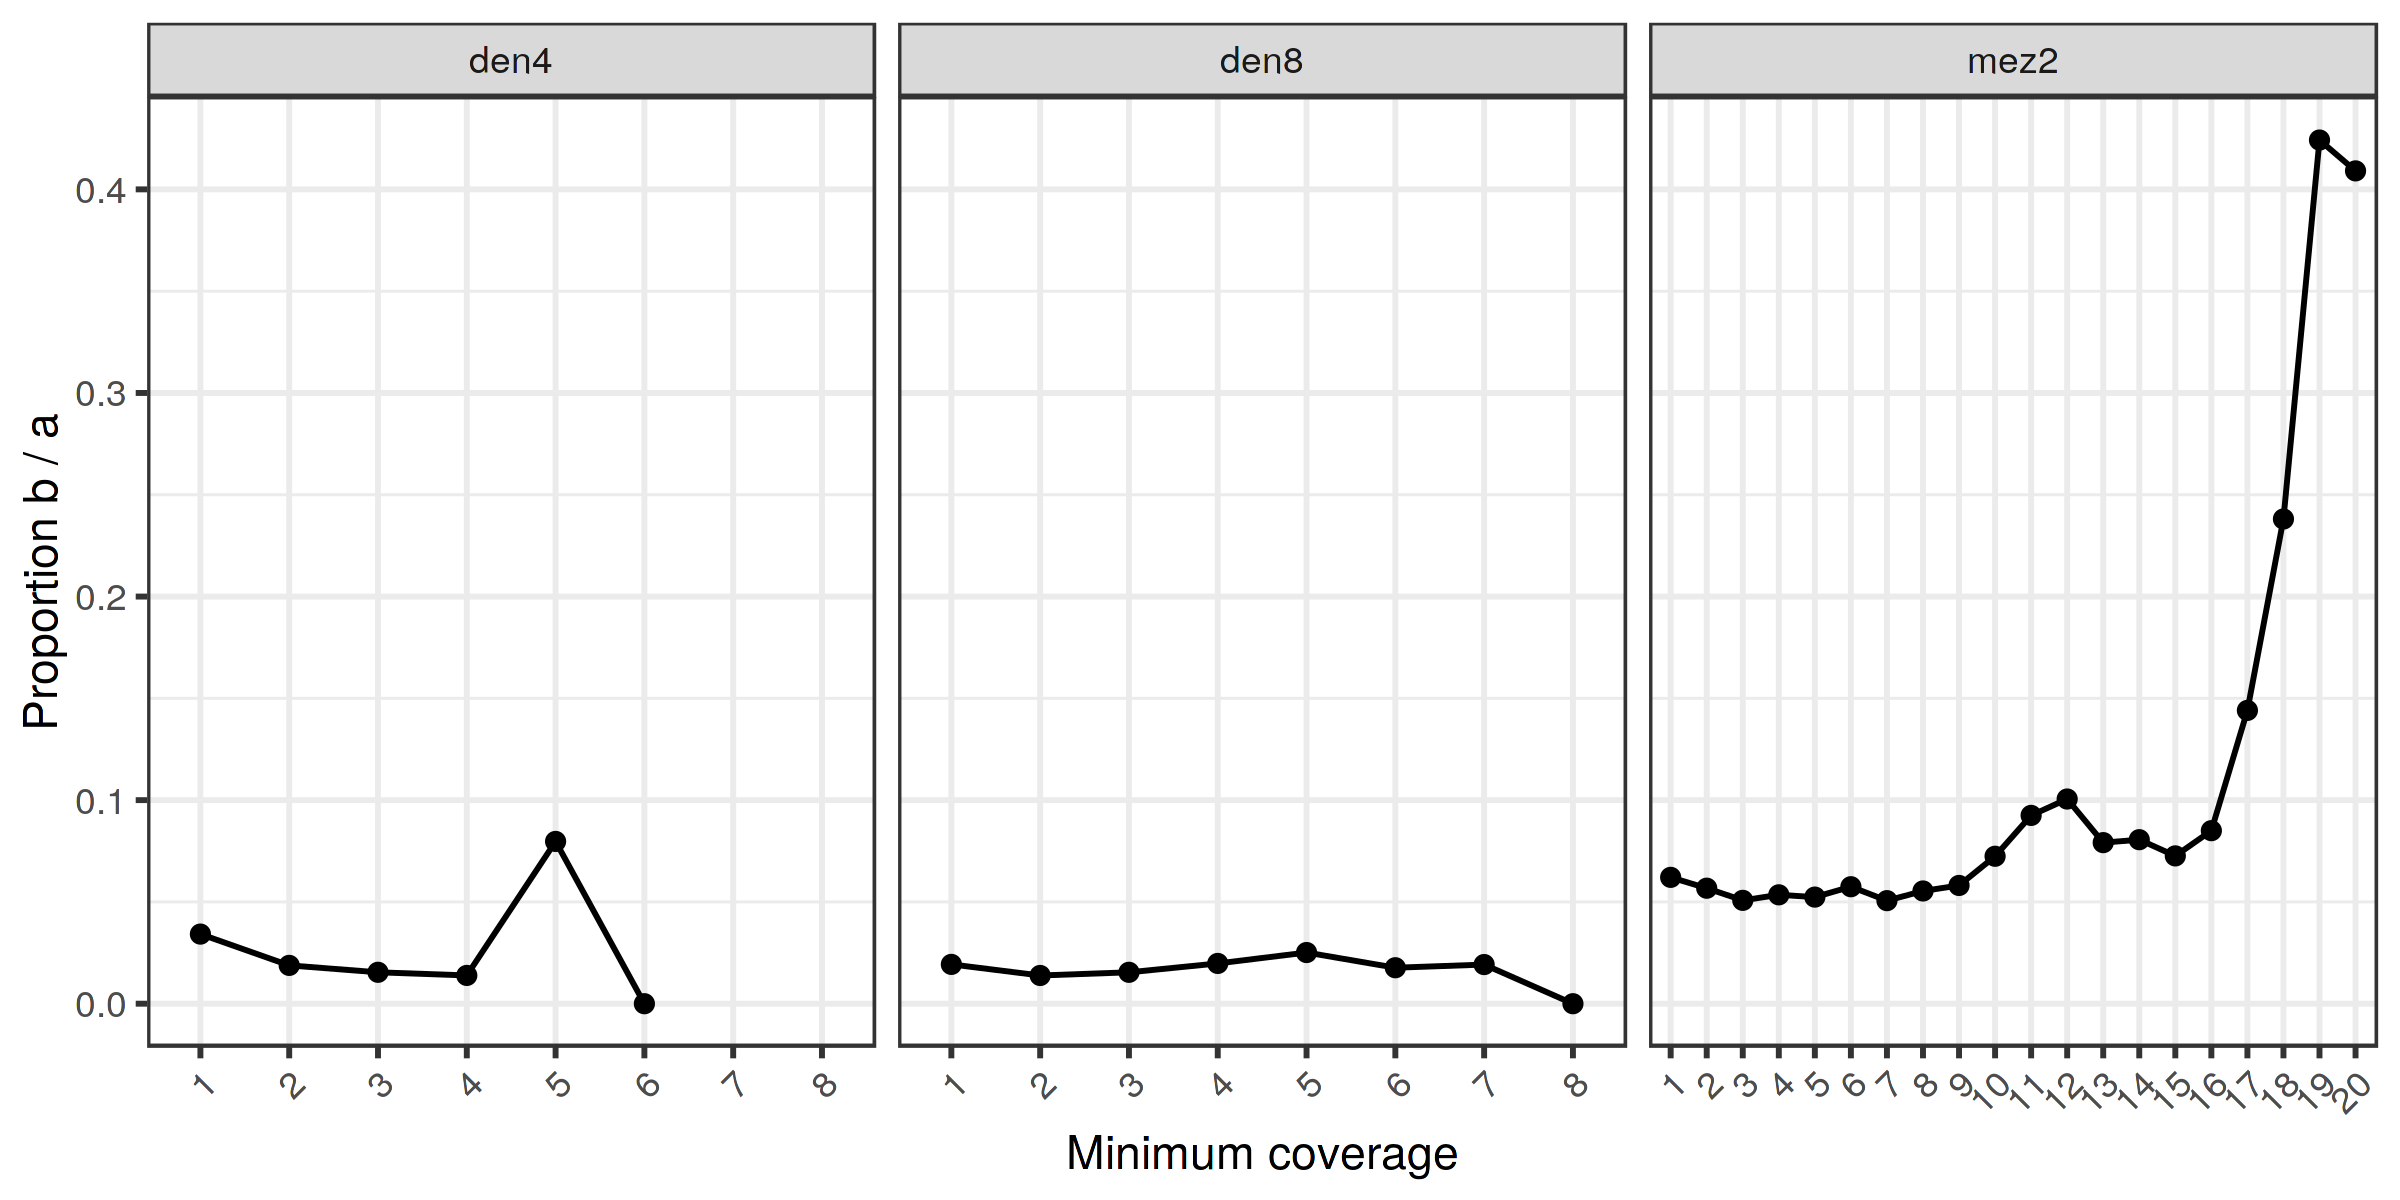

In [11]:
set_dim(8, 4)

tmrca_df %>%
filter(filt == "filt50", sites == "tv_only", capture == "full" & arch %in% c("den4", "den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = b / a) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion b / a") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

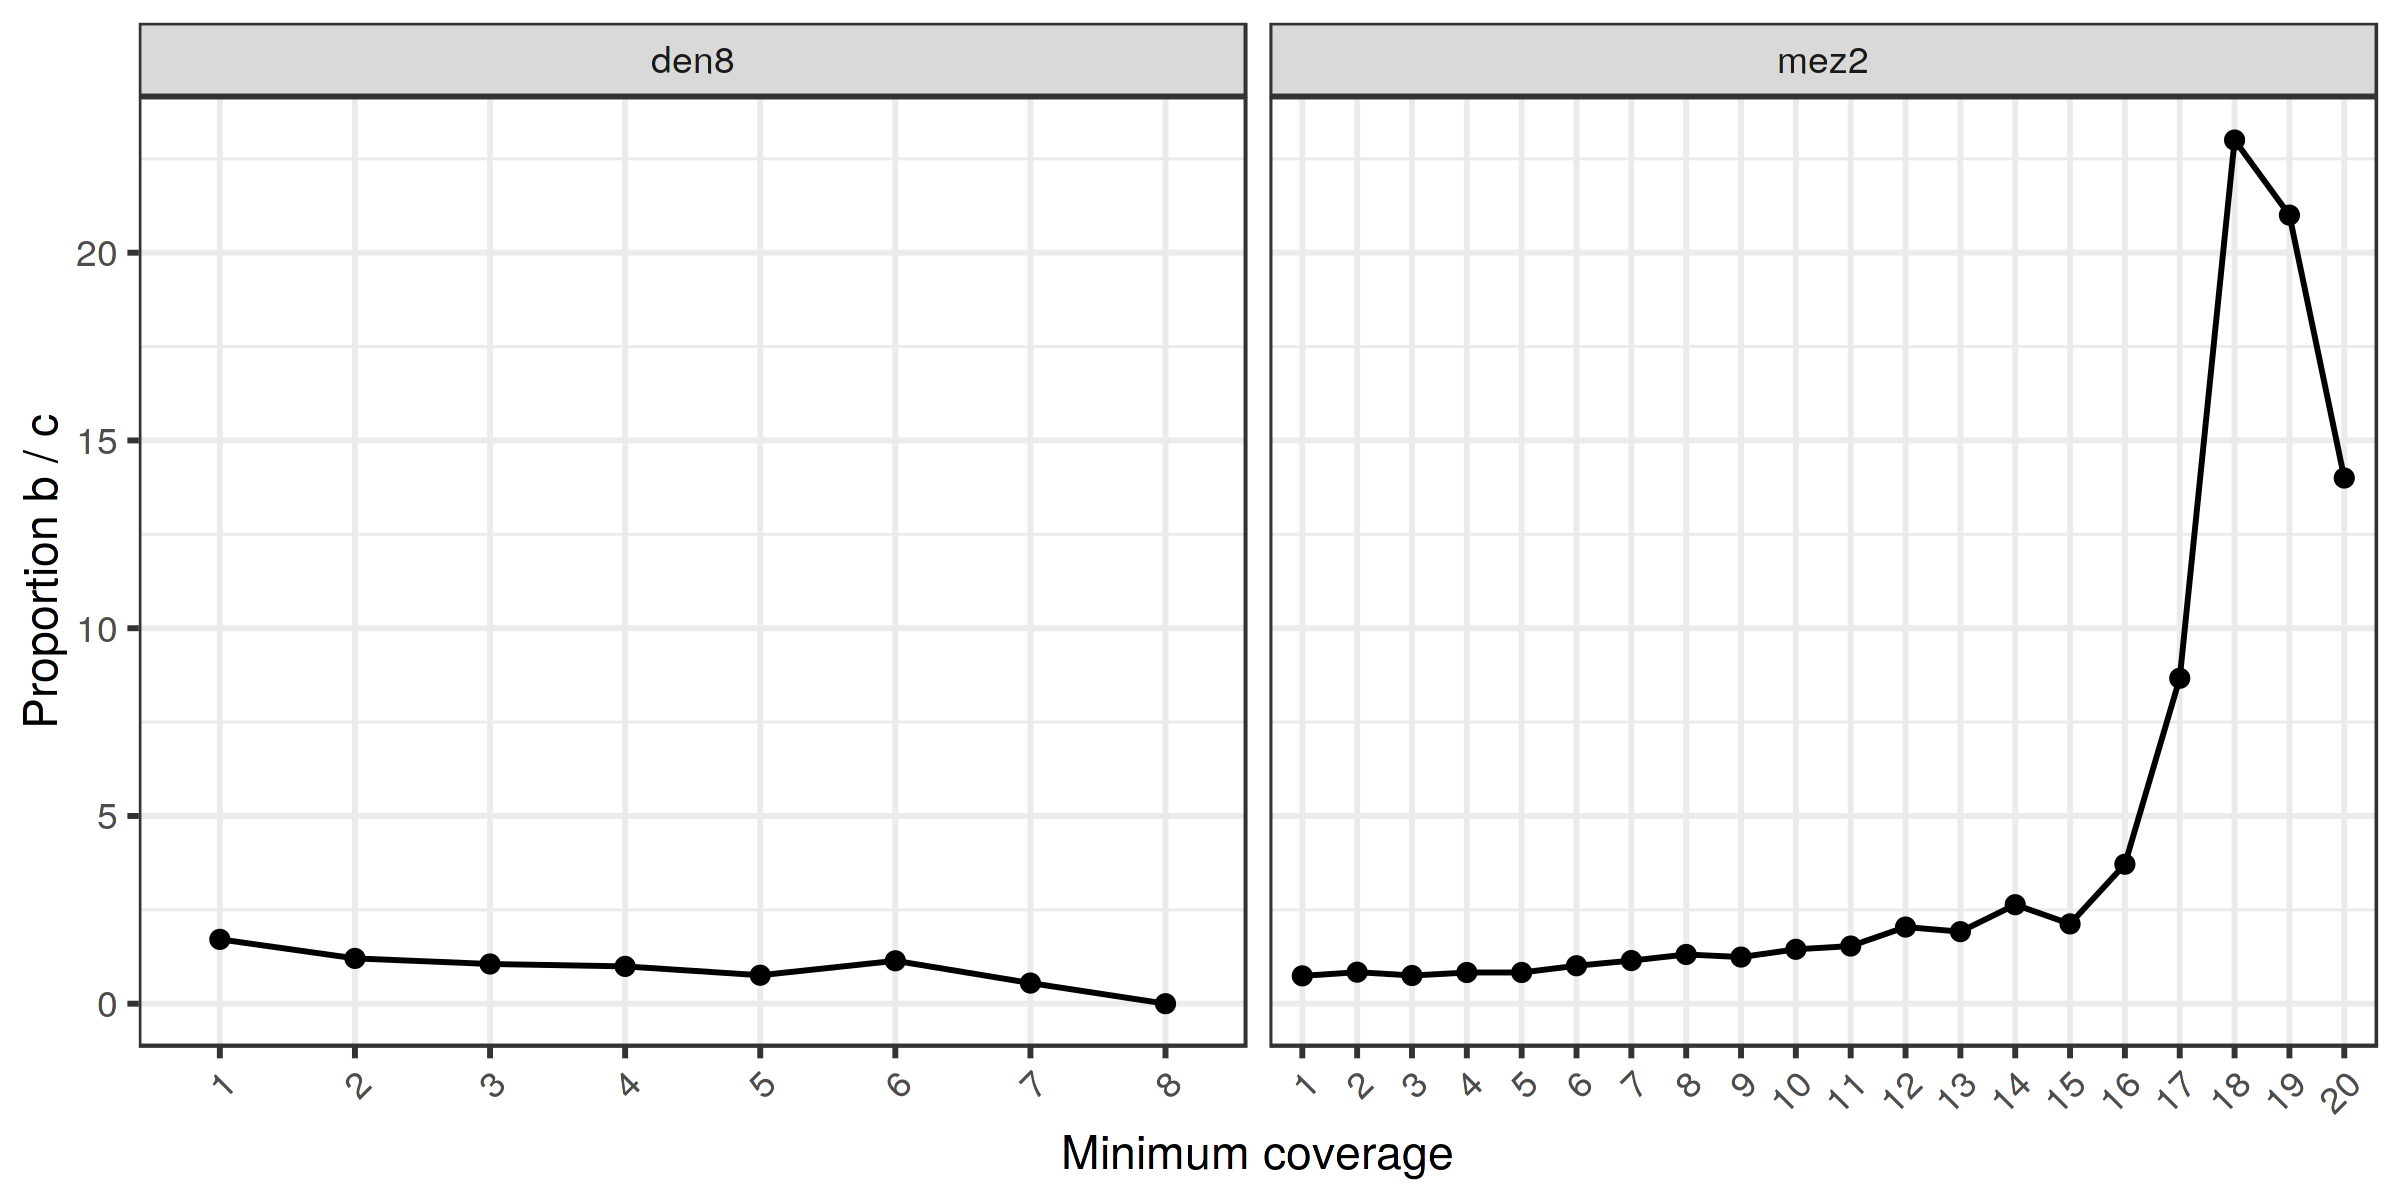

In [12]:
set_dim(8, 4)

tmrca_df %>%
filter(sites == "tv_only", capture == "full" & arch %in% c("den8", "mez2")) %>%
mutate(n_muts = a + b + c + d + e + f) %>%
group_by(arch, dp, sites) %>%
summarise_if(is.numeric, mean) %>%
mutate(prop = b / c) %>% 
ggplot(aes(as.factor(dp), prop)) +
    geom_point() +
    geom_line(group = 1) +
    facet_wrap(~ arch, scales = "free_x") +
    theme_bw() + xlab("Minimum coverage") + ylab("Proportion b / c") +
    theme(legend.position = "bottom", axis.text.x = element_text(hjust = 1, angle = 45))

points here:

1. 3X coverage seems to remove most of the error effects nicely - best argument for using this cutoff in the middle panel.
2. TV-only removes all erors (TMRCA doesn't change) => sequencing errors minimal beyond aDNA damage.
3. Minimal effect of reference bias with increasing coverage??? Based on the Neanderthal line in the center panel, but significant bias in Denisova?

TMRCAs of A00 are overlapping the ones of other Africans, especially striking in the Lippold captures, but exome data looks weird too - too much noise in the data or not enough sequence to accumulate enough informative sites?